## Two dimensional Bayesian Optimisation for continuous functions
We will define arbitrary two dimensional function $f(x)$ and use Bayesian Optimisation method to find its maximum.

Let us define a two-dimensional function of interest f as $(x^2 + y^2)(sin(x)^2 - cos(y))$. 

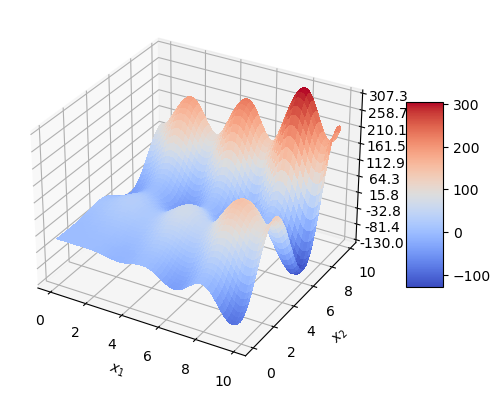

In [12]:
########################################################################################
# Two dimensional  Bayesian Optimisation for continuous function defined in 'objfunc2d'
########################################################################################

# Import required packages
import GPyOpt
from numpy.random import seed
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

####### Below: the code for plotting our 2-dimensional function ########

# Create the objective function
def obj_func_2d(x, y):
    return (x**2 + y**2)*(sin(x)**2 - cos(y))


# Set up plotting environment
fig = plt.figure(figsize=plt.figaspect(0.7))

# Make the data for plotting
X_1 = np.arange(0, 10, 0.1)
X_2 = np.arange(0, 10, 0.1)
X_1, X_2 = np.meshgrid(X_1, X_2)
Z = obj_func_2d(X_1, X_2)

# Setting up second subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Plotting the surface
surf = ax.plot_surface(X_1, X_2, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customizing the z axis
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax.set_zlim(-130, 307.26)

# Adding a color bar which maps values to colors
# and plotting the function of interest
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()



As illustrated in the figure above, this function contains many local maxima, but only one global
maximum within the region of interest $x_{1}, x_{2} ∈ [0, 10]$, representing the complexity required to really
test the effectiveness of the Bayesian optimisation algorithm.

Let us assume that all we know initially about our objective function f is a single data point, $f(x_1 = 0, x_2 = 0) = 0$. 

In [13]:
####### Below: the code for performing Bayesian optimisation ########

# Defining function of interest in the form
# which is usable with GPyOpt package
def objfunc2d(mydomain):
    x_1 = mydomain[:, 0]
    x_2 = mydomain[:, 1]
    return (x_1**2 + x_2**2)*(sin(x_1)**2 - cos(x_2))

# We can not start Bayesian Optimisation without observing at least a single data point
# of our function of interest. Hence we define single observation below:
# x_1 = x_2 = 0
X_init = np.array([[0.0,0.0]])
# f(x_1 = 0, x_2 = 0) = 0
Y_init = np.array([[0.0]])

# Setting up bounds for both variables
bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0, 10)}]



Additionally, we set our evaluation budget to be 35 iterations or stop the optimisation process if the distance between the last two observations is < $10^{−6}$

In [14]:
# Define optimisation budgets
max_iter = 35    # evaluation budget
max_time = 60    # time budget
eps = 10e-6      # minimum allowed distance between the last two observations

Now let's run Bayesian Optimisation with previously defined parameters to find global maximum and plot posterior mean, standard deviation and acquisition function (**expected improvement**)

Value of (x,y) that maximises the objective:[7.95145111 9.64315493]
Maximum value of the objective: 307.242544088916


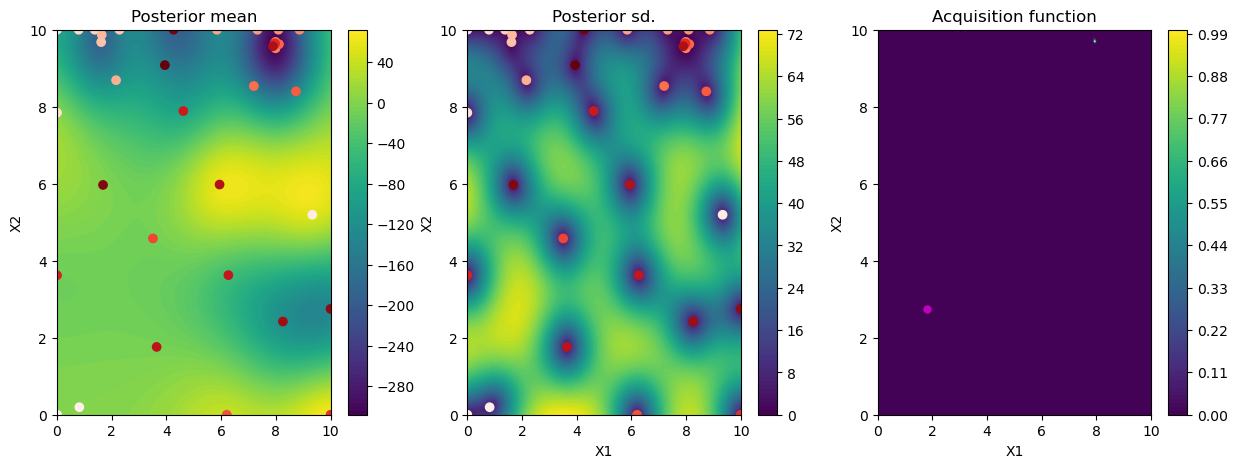

In [15]:
# Setting seed so that the same results could bet reproduced
seed(123)

TwoD_BO_EI = GPyOpt.methods.BayesianOptimization(X = X_init,            # X = (x_1, x_2) coordinate of the known observation
                                                Y = Y_init,             # f(x_1, x_2) value of the known observation
                                                f = objfunc2d,          # function to optimize
                                                domain=bounds2d,        # constraints of the problem
                                                acquisition_type='EI',  # selects the expected improvement acquisition function
                                                maximize=True,          # we are maximising our function
                                                exact_feval=True,       # we want exact outputs, not rounded
                                                normalize_Y=False,      # we choose not to rescale y axis
                                                initial_design_numdata= 1 # only one initial data point (defined as
# X and Y above) will be known before we start the optimisation
                                                )
# Run Optimization with defined optimisation budget
TwoD_BO_EI.run_optimization(max_iter, max_time, eps)

# Printing value of x and f(x) where function is found to be maximum
print("="*80)
print("Value of (x,y) that maximises the objective:"+str(TwoD_BO_EI.x_opt))
print("Maximum value of the objective: "+str((-1)*TwoD_BO_EI.fx_opt))
print("="*80)

# Plotting the acquisition function
TwoD_BO_EI.plot_acquisition()



In the *first two* figures above, the round dots represent location of each iteration. Note that, since we are minimising the negative of $f(x_1, x_2)$, posterior mean can take negative values in this plot.
The 3rd plot shows the current state of expected improvement function after 35 iterations (where the pink point represent location of the next evaluation if we were to perform 36th iteration).

Nopw convergence to that maximum can be visualised as

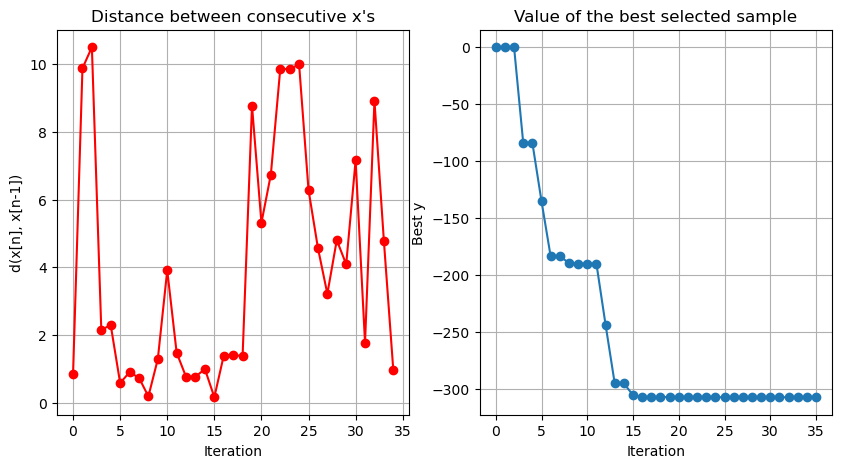

In [16]:
# Plotting convergence plots
TwoD_BO_EI.plot_convergence()


Both plots of posterior mean and posterior standard deviation indicate that locations of each iteration are fairly spread throughout the whole region of interest, suggesting a healthy balance between exploring areas of high uncertainty (where standard deviation have large values) and exploiting the local areas where global maximum is believed to be most likely located (left and right top corners of both plots). In addition to that, the convergence plot on the left (in red) provide further evidence that during optimisation there was a balanced trade-off between exploitation (where the distance between the last two evaluation locations is very small, i.e. throughout iterations 16 to 18) and exploration (where the distance between the last two evaluation locations is large, i.e. throughout iterations 29 to 32). One should also notice the intelligence acquisition function possesses just after the end of the optimisation process: since the majority of the region of interest ($x_1, x_2 ∈ [0, 10]$) was sufficiently explored and the evaluations at the top right corner of that region had much larger negative values of $−f(x_1, x_2)$, the expected improvement acquisition function tells us that we may already disregard most of the region, as there is certainty that the global maximum (or largest negative value of $−f(x_1, x_2)$) is located at the top right corner - that is why we observe the dominant dark violet colour in the acquisition function plot. What is more, looking at the right graph of convergence plots (in blue) we notice that global maximum was found just after 15 iterations, suggesting that when using expected improvement as the acquisition function for this two-dimensional problem we were not only able to find global maximum, but also do it quite efficiently.

# Runing optimisation using upper confidence bound acquisition function instead
Now let us compare how optimisation process differ if this time we are to use an upper confidence bound acquisition function instead. To begin with, we need to choose the value of parameter $ν$ which will be used for upper confidence bound function to determine the balance between exploration and exploitation. We will start with a value of $ν = 2$ since that is the default value within the GPyOpt package in Python. If we run the optimisation (keeping in mind the same settings as before - a 35 iteration budget, $x_1, x_2 ∈ [0, 10]$ region of interest and starting point of $f(0, 0) = 0$) we obtain initial output displayed below:

Value of (x,y) that maximises the objective:[1.60197774 9.81647054]
Maximum value of the objective: 190.27020142698143


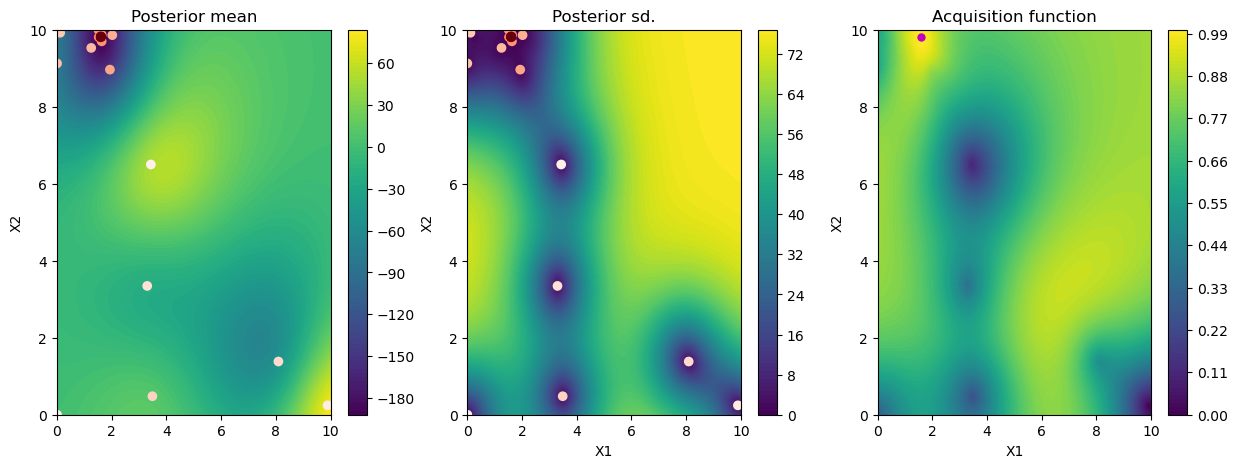

In [17]:
##################################################################################################
## Running optimisation again, but this time using upper UCB as acquistition function
##################################################################################################

# Defining function of interest in the form
# which is usable with GPyOpt package
def objfunc2d(mydomain):
    x_1 = mydomain[:, 0]
    x_2 = mydomain[:, 1]
    return (x_1**2 + x_2**2)*(sin(x_1)**2 - cos(x_2))

# We can not start Bayesian Optimisation without observing at least a single data point
# of our function of interest. Hence we define single observation below:
# x_1 = x_2 = 0
X_init = np.array([[0.0,0.0]])
# f(x_1 = 0, x_2 = 0) = 0
Y_init = np.array([[0.0]])

# Setting up bounds for both variables
bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0, 10)}]

# Define optimisation budgets
max_iter = 35    # evaluation budget
max_time = 60    # time budget
eps = 10e-6      # minimum allowed distance between the last two observations

# Setting seed so that the same results could bet reproduced
seed(123)

TwoD_BO_Conf1 = GPyOpt.methods.BayesianOptimization(X = X_init,            # X = (x_1, x_2) coordinate of the known observation
                                                Y = Y_init,             # f(x_1, x_2) value of the known observation
                                                f = objfunc2d,          # function to optimize
                                                domain=bounds2d,        # constraints of the problem
                                                acquisition_type='LCB',  # selects the confidence bound acquisition function
                                                maximize=True,          # we are maximising our function
                                                exact_feval=True,       # we want exact outputs, not rounded
                                                normalize_Y=False,      # we choose not to rescale y axis
                                                initial_design_numdata= 1 # only one initial data point (defined as
# X and Y above) will be known before we start the optimisation
                                                )
# Run Optimization with defined optimisation budget
TwoD_BO_Conf1.run_optimization(max_iter, max_time, eps)

# Printing value of x and f(x) where function is found to be maximum
print("="*80)
print("Value of (x,y) that maximises the objective:"+str(TwoD_BO_Conf1.x_opt))
print("Maximum value of the objective: "+str((-1)*TwoD_BO_Conf1.fx_opt))
print("="*80)

# Plotting the acquisition function
TwoD_BO_Conf1.plot_acquisition()



Clearly, the obtained maximum value $f(1.6, 9.82) = 190.27$ is **not** the global maximum. Examining the posterior mean (first plot on the left), we can immediately notice that majority of evaluations of each iteration were clustered at the top left corner of the domain, suggesting a poor balance between exploration and exploitation (with the latter being too significant). This is also well reflected in posterior standard deviation plot (middle plot), which indicates a high uncertainty for the top right corner of the domain. Not only that, the dominant colours of higher end of the colour bar scale (yellow-green) across entire domain in the upper confidence bound function (3rd plot on the far right) indicate that there is a lack of certainty as to where exactly the global maximum could potentially be located, even after 35 iterations of the optimisation. Similar uncertainties are visible in convergence outputs:

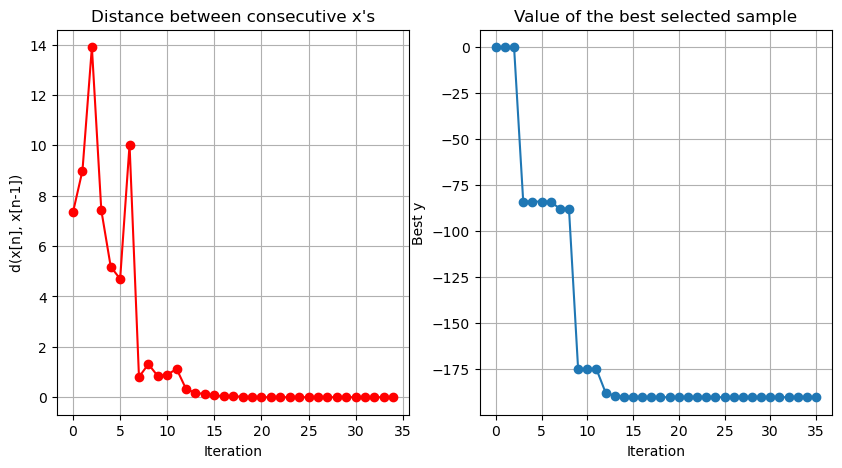

In [18]:
# Plotting convergence plots
TwoD_BO_Conf1.plot_convergence()

Hence, it may seem that an upper confidence bound acquisition function might not be suitable for this two-dimensional problem, but before we make this conclusion we aim to test if defining a better trade-off between exploration and exploitation can improve our optimisation results.
So in order to give more importance to the exploration of the uncertain areas, we increase our value of control parameter to $ν = 3$ and perform Bayesian optimisation once more. Looking at initial output below, we immediately notice that optimisation results have improved:

In [19]:
##################################################################################################
## Running optimisation again, but this time using UCB with parameter value nu = 3 as acquistition function
##################################################################################################
# Defining function of interest in the form
# which is usable with GPyOpt package
def objfunc2d(mydomain):
    x_1 = mydomain[:, 0]
    x_2 = mydomain[:, 1]
    return (x_1**2 + x_2**2)*(sin(x_1)**2 - cos(x_2))

# We can not start Bayesian Optimisation without observing at least a single data point
# of our function of interest. Hence we define single observation below:
# x_1 = x_2 = 0
X_init = np.array([[0.0,0.0]])
# f(x_1 = 0, x_2 = 0) = 0
Y_init = np.array([[0.0]])

# Setting up bounds for both variables
bounds2d = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 10)},
            {'name': 'var_2', 'type': 'continuous', 'domain': (0, 10)}]

# Define optimisation budgets
max_iter = 35    # evaluation budget
max_time = 60    # time budget
eps = 10e-6      # minimum allowed distance between the last two observations

# Setting seed so that the same results could bet reproduced
seed(123)

TwoD_BO_Conf2 = GPyOpt.methods.BayesianOptimization(X = X_init,            # X = (x_1, x_2) coordinate of the known observation
                                                Y = Y_init,             # f(x_1, x_2) value of the known observation
                                                f = objfunc2d,          # function to optimize
                                                domain=bounds2d,        # constraints of the problem
                                                acquisition_type='LCB',  # selects the confidence bound acquisition function
                                                maximize=True,          # we are maximising our function
                                                exact_feval=True,       # we want exact outputs, not rounded
                                                normalize_Y=False,      # we choose not to rescale y axis
                                                initial_design_numdata= 1 # only one initial data point (defined as
# X and Y above) will be known before we start the optimisation
                                                )

# Setting parameter value nu = 3
TwoD_BO_Conf2.acquisition.exploration_weight = 3

# Run Optimization with defined optimisation budget
TwoD_BO_Conf2.run_optimization(max_iter, max_time, eps)

# Printing value of x and f(x) where function is found to be maximum
print("="*80)
print("Value of (x,y) that maximises the objective:"+str(TwoD_BO_Conf2.x_opt))
print("Maximum value of the objective: "+str((-1)*TwoD_BO_Conf2.fx_opt))
print("="*80)

Value of (x,y) that maximises the objective:[7.93924815 9.66961641]
Maximum value of the objective: 307.2626189624744


In fact, the maximum value $f(7.939, 9.669) = 307.262$ is indeed a global maximum and is almost identical to the results we obtained when using expected improvement as our acquisition function. This resemblance is also visible in posterior mean and standard deviation plots, where locations of each iteration have a fairly even spread throughout the whole domain, indicating a fine balance between exploration and exploitation:

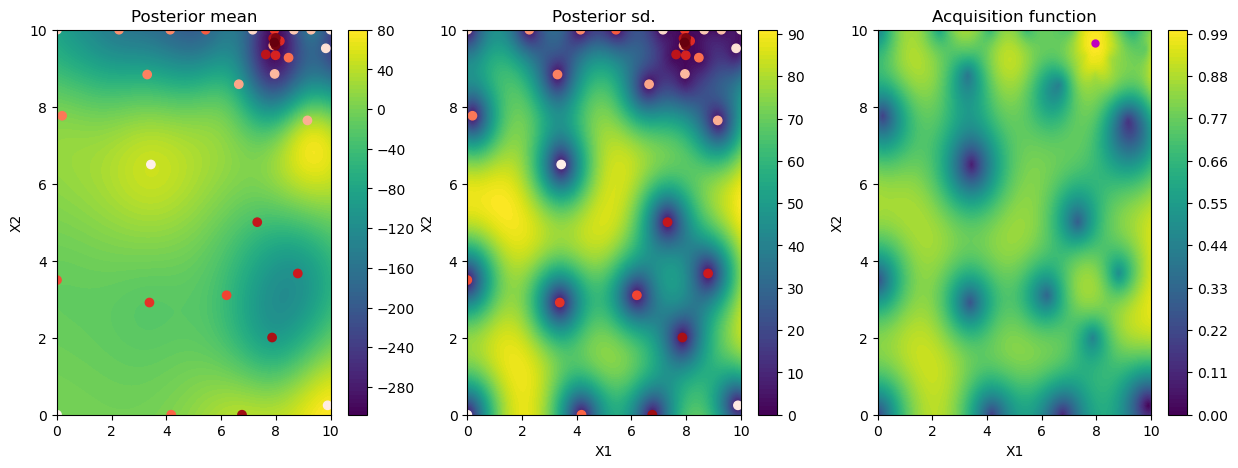

In [20]:
# Plotting the acquisition function
TwoD_BO_Conf2.plot_acquisition()

Further evidence of that is also present on the left convergence graph below, where large distances between consecutive evaluation locations suggest that much more exploration of uncertain areas was done using parameter value $ν = 3$ than using $ν = 2$.

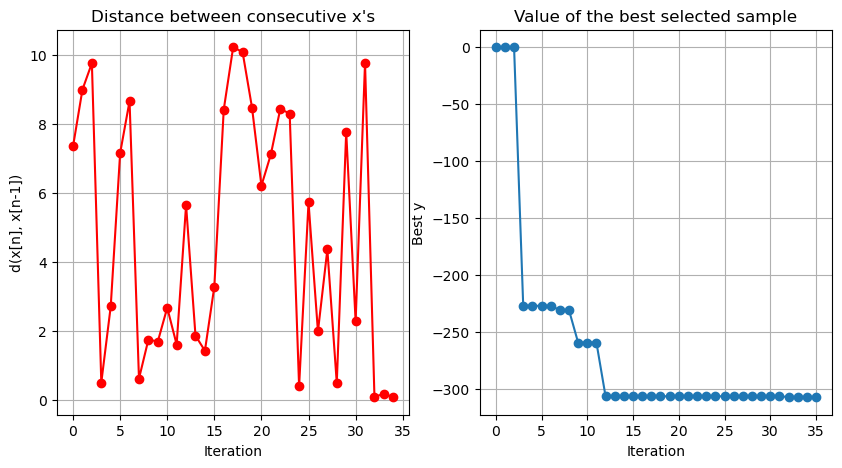

In [21]:
# Plotting convergence plots
TwoD_BO_Conf2.plot_convergence()

Lastly, looking at the graph on the right above, we notice that the best optimum value obtained has not changed significantly since the 12th iteration, suggesting a great efficiency in detecting global maximum. Thus, we may conclude that defining a better trade-off between exploration and exploitation (increasing the parameter value $ν$ in this case) can significantly improve the performance of the upper confidence bound function. One could also argue that this choice of acquisition function may be preferred over expected improvement for our two-dimensional optimisation problem as when using upper confidence bound function the global maximum was located (up to a slight difference of $±0.5$) slightly quicker - 12 iterations for upper confidence bound compared to 16 for expected improvement.


*Please refer to pdf thesis document for full in depth analysis of this exmaple and the theory behind it.*